In [53]:
import numpy as np

import matplotlib.pyplot as plt

# Burger's Equation

The inviscid Burger's equation is the simplest nonlinear wave equation and serves as a great stepping stone toward doing full hydrodynamics.

$$ u_{t} + u u_{x} = 0 $$

This looks like the linear advection equation, except the quantity being advected is the velocity itself. This means that $u$ is no longer constant but can vary in space and time. 

Written in conservative form:

$$ \frac{\partial u}{\partial t} + \frac{\partial F(u)}{\partial x} = 0 $$

it appears as:

$$ u_{t} + \left [ \frac{1}{2} u^2 \right ]_{x} = 0 $$

so the flux is $ F(u) = \frac{1}{2} u^2 $.

In the finite volumes approach, we integrate over the volume of the cell to get the update:

$$ \frac{\partial \langle u \rangle_{i}}{\partial t} = -\frac{1}{\Delta x} (F_{i+1/2} - F_{i-1/2}) $$

To the second order accuracy, as we saw previously, $ \langle u \rangle_{i} \approx u_{i} $.

Our solution method is essentially the same, aside from the Riemann problem. We still want to use the idea of upwainding, but now we have a problem. The nonlinear nature of the Burger's equation means that information will "pile up" and we lose track of where the flow is coming from which gives rise to a nonlinear wave called a shock.

For the linear advection equation, the solution was unchanged along the lines $ x-ct = \text{constant} $, called characteristic curves.

We can visualize the characteristics as shown below:

![characteristic curves](https://drive.google.com/uc?id=12tVdD-roRautPE5wDGtz0T0UC_OKCDVM)

The top panel shows the initial $a(x, t=0)$ and the bottom shows the characteristic curves in the $x-t$ space-time diagram. We see that at any $t>0$ we find the value of $a(x, t)$ by simply tracing backwards along the characteristic curve to the initial conditions. Since $u$ is constant in the advection equation, the characteristic curves are parallel.

The characteristice curves are the curves on which the solution is constant. For Burger's equation, the characteristic curves are given by $dx/dt = u$, but now $u$ varies in the domain. To see this, look at the change of $u$ in a fluid element (the full or Langrangian derivative):

$$ \frac{du}{dt} = \frac{\partial u}{\partial t} + \frac{\partial x}{dt} \frac{\partial u}{\partial x} = \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0 $$

We see that $du/dt = 0$ since it just gives us the Burger equation. So $u$ is constant along the curves $dx/dt = 0$, but now $u$ $u$ vaires in the domain. So if we look at the characteristic curves in the spacetime diagram, we get:

![Burger's Shock](https://drive.google.com/uc?id=16ie_j7ZUw2_Jsa4wDzONwmLckMGYeibM)

Now we see that for these initial conditions, at some point in the future the characteristic curves intersect. This means that there is not a unique curve that we can trace back along to find the value of $u(x, t)$. The information about where the solution was coming from was lost. This is the situation of a shock. The correct solution here is to put a discontinuous jump between the left and right states where the characteristics intersect. The speed of the chock can be found from the [Rankine-Hugoniot Conditions](https://en.wikipedia.org/wiki/Rankine%E2%80%93Hugoniot_conditions).

It is possible to get a rarefaction if the characteristics diverge:

![Rarfaction Shock](https://drive.google.com/uc?id=1Q1hUkglMguAKaH04b9JJzOt2VNsY207l)

# Numerical Solution

We will use the same finite-volume grid class with one change -- we will allow for "outflow" boundary conditions. These somply enforce a zero gradiant in the ghost cells, so:

$$ u_{lo-1} = u_{lo} $$
$$ u_{lo-2} = u_{lo} $$

and similar at the right boundary.

In [54]:
class FVGrid:

  def __init__(self, nx, ng, bc="outflow", xmin=0.0, xmax=1.0):
    self.xmin = xmin
    self.xmax =xmax
    self.ng = ng
    self.nx = nx

    # python is zero based so make easy integers to where the real data lives
    self.ilo = ng
    self.ihi = ng+nx-1

    # physical coordinates - cell-centerd, left and right edgwes
    self.dx = (xmax - xmin) / nx
    self.x = xmin + (np.arange(nx + 2 * ng) - ng + 0.5) * self.dx
    self.xl = xmin + (np.arange(nx + 2 * ng) - ng) * self.dx
    self.xr = xmin + (np.arange(nx + 2 * ng) - ng + 1.0) * self.dx

    # store the solution
    self.u = self.scratch_array()
    self.uinit = self.scratch_array()

    self.bc = bc

  def scratch_array(self):
     """return a scratch array dimensioned for our grid""" 
     return np.zeros((self.nx + 2 * self.ng), dtype = np.float64)

  def fill_BCs(self, atmp):
    """fill the ghost cells"""
    if self.bc == "periodic":
      # left boundary condition
      atmp[0:self.ilo] = atmp[self.ihi-self.ng + 1:self.ihi + 1]

      # right boundary condition
      atmp[self.ihi + 1:] = atmp[self.ilo:self.ilo + self.ng]
      
    elif self.bc == "outflow":
      # left boundary condition
      atmp[0:self.ilo] = atmp[self.ilo]

      # right boundary condition
      atmp[self.ihi + 1:] = atmp[self.ihi]

    else:
      sys.exit("invalid BC")

  def norm(self, e):
    """return the norm of the quantity e which lives on the grid"""
    if not len(e) == (2 * slef.ng + self.nx):
      return None

    return np.sqrt(self.dx * np.sum(e[self.ilo:self.ihi]**2))

  def plot(self):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(self.x, self.uinit, label="initial conditions")
    ax.plot(self.x, self.u)
    ax.legend()
    return fig

The Riemann problem is more complicated. If there is compression $u_{l} > u_{r}$, then we have a shock and we need to compute the shock speed and then upwind based on that. For the Burger's equation, the shock speed is obtained via the Rankine-Hugoniot conditions as:

$$S = \frac{f(u_{r}) - f(u_{l})}{u_r - u_l} = \frac{\frac{1}{2} u^{2}_{r} - \frac{1}{2} u^{2}_{l}}{u_r - u_l} = \frac{1}{2} (u_l + u_r) $$

For an interface in our domain:

$$ S= \frac{1}{2} (u_{i+1/2, L} + u_{i+1/2, R}) $$

Then our Riemann problem is

$$ u_{i+1/2} = \mathcal{R}(u_{u+1/2, L}, u_{i+1/2, R}) = \left \{ \begin{array} & u_s & \text{if} \phantom{a} u_{i+1/2, L} > u_{i+1/2, R} \\ u_r & \text{otherwise} \end{array} \right .$$

where $u_s$ is the shock case

$$ u_s = \left\{ \begin{array} & u_{i+1/2, L} & \text{if} \phantom{a} u_{i+1/2, L} > 0 \\ u_{i+1/2, R} & \text{if} \phantom{a} u_{i+1/2, R} < 0 \\ 0 & \text{otherwise} \end{array} \right .$$

Once we have the interface state, $u_{i+1/2$, we can compute the flux:

$$ F_{i+1/2} = \frac{1}{2} u^{2}_{i+1/2} $$

and then the divergence of the fluxes:

$$ - \frac{1}{\Delta x} (F_{i+1/2} - F_{i-1/2}) = -\frac{1}{\Delta x} \left(\frac{1}{2} u^{2}_{i+1/2} - \frac{1}{2} u^{2}_{i-1/2} \right) $$

In [64]:
def flux_update(gr, u):
  """compute -div(F) for the linear advection"""

  # slope -- using the minmod limiter

  # dl = u_i - u_{i-1}
  dl = gr.scratch_array()
  dl[gr.ilo-1:gr.ihi+2] = u[gr.ilo-1:gr.ihi+2] - u[gr.ilo-2:gr.ihi+1]

  # dr = u_{i+1} - u_i
  dr = gr.scratch_array()
  dr[gr.ilo-1:gr.ihi+2] = u[gr.ilo:gr.ihi+3] - u[gr.ilo-1:gr.ihi+2]

  d1 = np.where(np.fabs(dl) < np.fabs(dr), dl, dr)
  du = np.where(dl * dr > 0.0, d1, 0.0)

  # unlimited
  # du[gr.ilo-1:gr.ihi+2] = 0.5 * (u[gr.ilo:gr.ihi+3] - u[gr.ilo-2:gr.ihi+1])

  # compute the left and right interfaces
  # Note that there are 1 more interfaces than zones
  # u_{i-1/2, R} = u_i - 1/2 * du_i
  ur = gr.scratch_array()
  ur[gr.ilo:gr.ihi+2] = u[gr.ilo:gr.ihi+2] - 0.5 * du[gr.ilo:gr.ihi+2]

  # u_{i-1/2, L} = u_i + 1/2 * du_i
  ul = gr.scratch_array()
  ul[gr.ilo:gr.ihi+2] = u[gr.ilo-1:gr.ihi+1] + 0.5 * du[gr.ilo-1:gr.ihi+1]

  # now do the Riemann Problem
  S = 0.5 * (ul + ur)
  ushock = np.where(S > 0.0, ul, ur)
  ushock = np.where(S == 0.0, 0.0, ushock)

  # rarefection solution
  urare = np.where(ur <= 0.0, ur, 0.0)
  urare = np.where(ul >= 0.0, ul, urare)

  # if we are compressive there we are a shock
  us = np.where(ul > ur, ushock, urare)

  flux_diff = gr.scratch_array()
  flux_diff[gr.ilo:gr.ihi+1] = (0.5 * us[gr.ilo:gr.ihi+1]**2 - 0.5 * us[gr.ilo+1:gr.ihi+2]**2) / gr.dx

  return flux_diff

Now the main driver. The main difference here compared to the linear advection is that we need to recompute dt each timestep, since $u$ changes in space and time.

In [65]:
def burgers_mol(nx, C, tmax, init_cond=None):

  # create the grid
  g = FVGrid(nx, ng=2)

  # setup the initial conditions
  init_cond(g)

  g.uinit[:] = g.u[:]

  t = 0.0

  while t < tmax:

    # compute the timespte
    dt = C * g.dx / np.abs(g.u).max()

    if t + dt > tmax:
      dt = tmax - t
    
    # second-order RK integration
    g.fill_BCs(g.u)
    k1 = flux_update(g, g.u)

    utmp = g.scratch_array()
    utmp[:] = g.u[:] + 0.5 * dt * k1[:]

    g.fill_BCs(utmp)
    k2 = flux_update(g, utmp)

    g.u[:] += dt * k2[:]

    t+= dt

  return g

Let us test this out with a sine-like initial conditions. Based on the characteristics shown above, this should result in a shock

In [66]:
def sine(g):
  g.u[:] = 1.0

  index = np.logical_and(g.x >= 0.333, g.x <= 0.666)
  g.u[index] += 0.5 * np.sin(2.0 * np.pi * (g.x[index] - 0.333)/0.333)

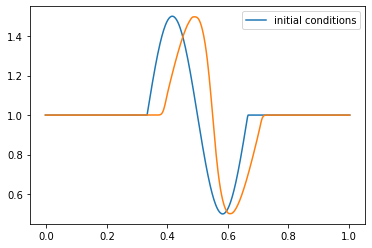

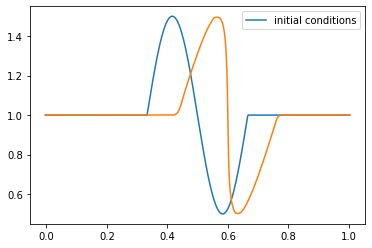

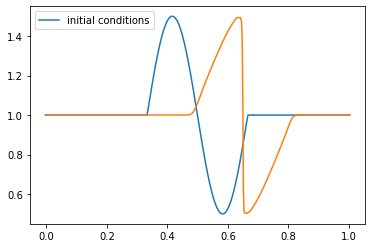

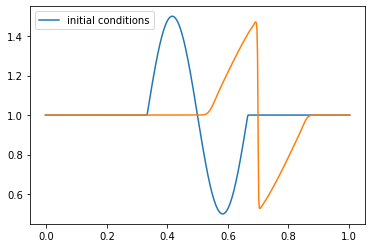

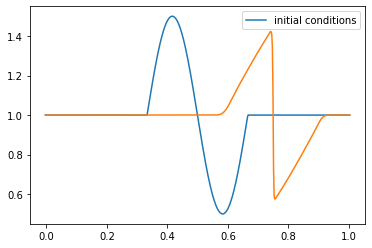

In [68]:
nx = 512
C = 0.5
tmax = 0.25

for tmax in [0.05, 0.10, 0.15, 0.20, 0.25]:
  g = burgers_mol(nx, C, tmax, init_cond=sine)
  fig = g.plot()

Keep in mind that although our method idally converges as second order in space and time, the slope limiter we use kicks in near discontinuities and reduces the converges locally to first order

# Exercise

Implement initial conditions that will give rise to a rarefaction and evolve Burger's equation

In [69]:
def rare(g):
  g.u[:] = 1.0
  g.u[g.x > 0.5] = 2.0

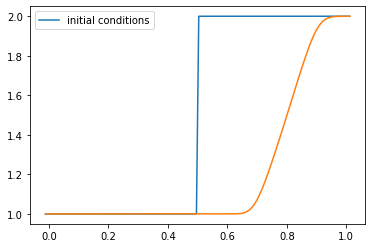

In [70]:
nx = 128
C = 0.5
tmax = 0.2

g = burgers_mol(nx, C, tmax, init_cond=rare)
fig = g.plot()

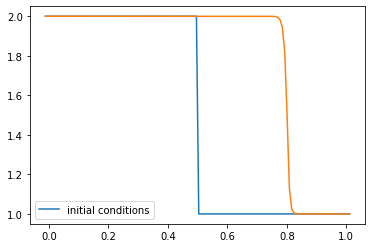

In [71]:
def shock(g):
  g.u[:] = 2.0
  g.u[g.x > 0.5] = 1.0

g = burgers_mol(nx, C, tmax, init_cond=shock)
fig = g.plot()

We see that at the end, the shock is a ta position of 0.8 and that it started at 0.5. We can just compute the shock speed as $(x_{final} - x_{initial}) / \Delta t $

In [72]:
(0.8 - 0.5) / tmax

1.5000000000000002

This is the expected result from the jump conditions. Because we solve the Riemann Problem, which knows about the jump conditions, we get the speed of the shock corrent. There methods are sometimes called shock-capturing methods.